In [1]:
#importing libraries
import pandas as pd
import numpy as np

from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/transactions.csv")

## Exploratory Data Analysis

In [3]:
shape = df.shape

print(f"Our dataset has {shape[0]} rows and {shape[1]} columns.")

Our dataset has 299695 rows and 17 columns.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [5]:
## numerical columns statistics

df.describe()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,promo_used,avs_match,cvv_result,three_ds_flag,shipping_distance_km,is_fraud
count,299695.0000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000
mean,149848.0000,3002.559432,973.397871,50.673321,148.142973,177.165279,0.153640,0.837999,0.872110,0.784588,357.049028,0.022062
std,86514.6388,1732.309663,525.241409,5.976391,200.364624,306.926507,0.360603,0.368453,0.333968,0.411109,427.672074,0.146887
min,1.0000,1.000000,1.000000,40.000000,3.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74924.5000,1501.000000,516.000000,46.000000,46.190000,42.100000,0.000000,1.000000,1.000000,1.000000,136.600000,0.000000
50%,149848.0000,3007.000000,975.000000,51.000000,90.130000,89.990000,0.000000,1.000000,1.000000,1.000000,273.020000,0.000000
75%,224771.5000,4504.000000,1425.000000,56.000000,173.450000,191.110000,0.000000,1.000000,1.000000,1.000000,409.180000,0.000000
max,299695.0000,6000.000000,1890.000000,60.000000,4565.290000,16994.740000,1.000000,1.000000,1.000000,1.000000,3748.560000,1.000000


In [6]:
#check for missing values

df.isnull().sum()

transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

In [7]:
## check for duplicate values

df['transaction_id'].duplicated().value_counts()

transaction_id
False    299695
Name: count, dtype: int64

In [8]:
# target variable
df['is_fraud'].value_counts()

is_fraud
0    293083
1      6612
Name: count, dtype: int64

In [9]:
df['is_fraud'].value_counts(normalize=True)*100

is_fraud
0    97.793757
1     2.206243
Name: proportion, dtype: float64

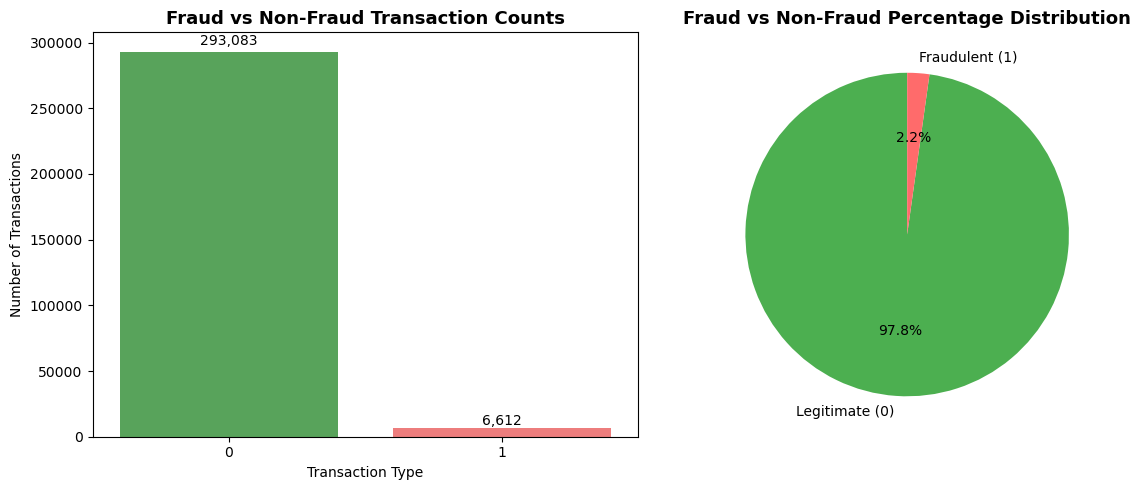

In [10]:
# Visualize target variable distribution (is_fraud) — updated for seaborn 0.14+

import matplotlib.pyplot as plt
import seaborn as sns

fraud_counts = df['is_fraud'].value_counts().sort_index()
fraud_labels = ['Legitimate (0)', 'Fraudulent (1)']

# Prepare a small DataFrame for plotting
fraud_df = pd.DataFrame({
    'is_fraud': fraud_counts.index,
    'count': fraud_counts.values
})

# Create a figure with two subplots: bar + pie
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Bar Chart (updated style)
sns.barplot(
    data=fraud_df,
    x='is_fraud',
    y='count',
    hue='is_fraud',        # assign hue for colors
    palette=['#4CAF50', '#FF6B6B'],
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Fraud vs Non-Fraud Transaction Counts', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Number of Transactions')

# Add text labels on bars
for i, count in enumerate(fraud_counts.values):
    axes[0].text(i, count + (count * 0.01), f'{count:,}', ha='center', va='bottom', fontsize=10)

# 2️⃣ Pie Chart
axes[1].pie(fraud_counts.values, labels=fraud_labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF6B6B'])
axes[1].set_title('Fraud vs Non-Fraud Percentage Distribution', fontsize=13, fontweight='bold')

# Save the visualization
plt.tight_layout()
plt.savefig("../images/fraud_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
numerical_features = [
    'account_age_days',
    'total_transactions_user',
    'avg_amount_user',
    'amount',
    'shipping_distance_km'
]

categorical_features = [
    'country',
    'bin_country',
    'channel',
    'merchant_category',
    'promo_used',
    'avs_match',
    'cvv_result',
    'three_ds_flag'
]

time_feature = 'transaction_time'

target = 'is_fraud'


In [12]:
def mutual_info_score_churn(series):
    return mutual_info_score(series,df['is_fraud'])

In [13]:
mi = df[categorical_features].apply(mutual_info_score_churn)

mi.sort_values(ascending=False)


avs_match            0.016906
cvv_result           0.014895
three_ds_flag        0.010293
channel              0.004789
promo_used           0.001850
country              0.000213
bin_country          0.000098
merchant_category    0.000019
dtype: float64

In [14]:
#correlation of numerical features
df[numerical_features].corrwith(df['is_fraud'])

account_age_days          -0.120340
total_transactions_user   -0.017093
avg_amount_user           -0.001236
amount                     0.202499
shipping_distance_km       0.270004
dtype: float64

In [15]:
for col in df.columns:
    print(f"column_name:{col}")
    print(f"unique values : {df[col].nunique()}")# gives the total number of unique values
    print(f"first five unique values {df[col].unique()[:5]}") 
    print()

column_name:transaction_id
unique values : 299695
first five unique values [1 2 3 4 5]

column_name:user_id
unique values : 6000
first five unique values [1 2 3 4 5]

column_name:account_age_days
unique values : 1801
first five unique values [ 141 1598  954  566  497]

column_name:total_transactions_user
unique values : 21
first five unique values [47 57 40 59 53]

column_name:avg_amount_user
unique values : 5347
first five unique values [147.93  78.39 172.03 412.83  71.23]

column_name:amount
unique values : 60043
first five unique values [ 84.75 107.9   92.36 112.47 132.91]

column_name:country
unique values : 10
first five unique values ['FR' 'US' 'TR' 'PL' 'ES']

column_name:bin_country
unique values : 10
first five unique values ['FR' 'US' 'RO' 'ES' 'TR']

column_name:channel
unique values : 2
first five unique values ['web' 'app']

column_name:merchant_category
unique values : 5
first five unique values ['travel' 'fashion' 'electronics' 'grocery' 'gaming']

column_name:promo_used

Correlation Matrix:



,account_age_days,total_transactions_user,avg_amount_user,amount,shipping_distance_km,is_fraud
account_age_days,1.000000,-0.034347,-0.009951,-0.032084,-0.031924,-0.120340
total_transactions_user,-0.034347,1.000000,-0.004743,-0.005819,-0.005559,-0.017093
avg_amount_user,-0.009951,-0.004743,1.000000,0.731955,-0.000942,-0.001236
amount,-0.032084,-0.005819,0.731955,1.000000,0.053686,0.202499
shipping_distance_km,-0.031924,-0.005559,-0.000942,0.053686,1.000000,0.270004
is_fraud,-0.120340,-0.017093,-0.001236,0.202499,0.270004,1.000000


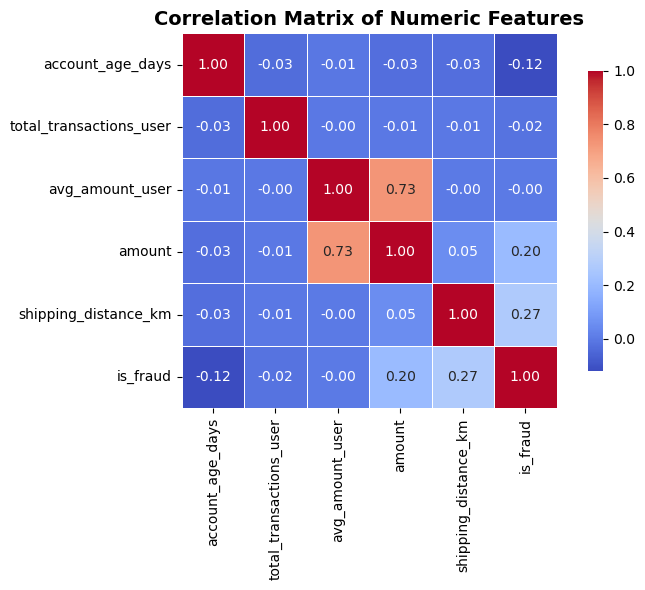

In [16]:
num_corr_features = numerical_features+['is_fraud']
corr_matrix = df[num_corr_features].corr()

# Display matrix
print("Correlation Matrix:\n")
display(corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Matrix of Numeric Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../images/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

## Feature Engineering and Preprocessing

In [17]:
## drop identifier columns

df = df.drop(labels=['transaction_id','user_id'],axis=1)

In [18]:
df['amount_per_avg_ratio'] = df['amount']/df['avg_amount_user']

df['cross_country_flag']=(df['bin_country']!=df['country']).astype(int)

In [19]:
country_freq = df['country'].value_counts(normalize=True)
bin_country_freq = df['bin_country'].value_counts(normalize=True)
df['country_freq'] = df['country'].map(country_freq)
df['bin_country_freq'] = df['bin_country'].map(bin_country_freq)
df = df.drop(['country', 'bin_country'], axis=1)

In [20]:
# create a time based features
#convert time 
df['transaction_time'] = pd.to_datetime(df['transaction_time'],utc=True)

df['hour'] = df['transaction_time'].dt.hour
df['day_of_week'] = df['transaction_time'].dt.dayofweek
df['is_night'] = np.where((df['hour'] >= 0) & (df['hour'] <= 6), 1, 0)
df = df.drop(['transaction_time'],axis=1)

In [21]:
df.dtypes

account_age_days             int64
total_transactions_user      int64
avg_amount_user            float64
amount                     float64
channel                     object
merchant_category           object
promo_used                   int64
avs_match                    int64
cvv_result                   int64
three_ds_flag                int64
shipping_distance_km       float64
is_fraud                     int64
amount_per_avg_ratio       float64
cross_country_flag           int64
country_freq               float64
bin_country_freq           float64
hour                         int32
day_of_week                  int32
is_night                     int64
dtype: object

In [26]:
numerical_features = [
    "account_age_days",
    "total_transactions_user",
    "avg_amount_user",
    "amount",
    "promo_used",
    "avs_match",
    "cvv_result",
    "three_ds_flag",
    "shipping_distance_km",
    "amount_per_avg_ratio",
    "cross_country_flag",
    "country_freq",
    "bin_country_freq",
    "hour",
    "day_of_week",
    "is_night"
]

categorical_features = [
    "channel",
    "merchant_category",
]

target = 'is_fraud'


In [27]:
### split the dataset into 60% training, 20% validation and 20% testing

df_full_train,df_test = train_test_split(df,test_size=0.20,random_state=42,stratify=df[target])
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=42,stratify=df_full_train[target])

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [28]:
#setting up features and target variables

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_full_train = df_full_train[target]

df_train = df_train[categorical_features+numerical_features]
df_val = df_val[categorical_features+numerical_features]
df_test = df_test[categorical_features+numerical_features]
df_full_train = df_full_train[categorical_features+numerical_features]




In [34]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [35]:
print(X_train.shape, X_val.shape, X_test.shape)


(179817, 23) (59939, 23) (59939, 23)


In [36]:
dv.get_feature_names_out()


array(['account_age_days', 'amount', 'amount_per_avg_ratio',
       'avg_amount_user', 'avs_match', 'bin_country_freq', 'channel=app',
       'channel=web', 'country_freq', 'cross_country_flag', 'cvv_result',
       'day_of_week', 'hour', 'is_night', 'merchant_category=electronics',
       'merchant_category=fashion', 'merchant_category=gaming',
       'merchant_category=grocery', 'merchant_category=travel',
       'promo_used', 'shipping_distance_km', 'three_ds_flag',
       'total_transactions_user'], dtype=object)